In [53]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, LSTM, SimpleRNN, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [54]:
# Load dataset metadata
def load_flickr8k_data(captions_file, image_dir):
    captions = open(captions_file, 'r').read().strip().split('\n')
    # print(captions[0])
    # print(captions[1])
    image_to_captions = {}
    cnt = 0
    for caption in captions[1:]:  # Skip header
        parts = caption.split(',')
        if len(parts) < 2: continue
        img_id, desc = parts[0].split('.')[0], ','.join(parts[1:]).strip()
        # if(cnt == 0):
        #     print(desc)
        
        image_path = os.path.join(image_dir, img_id + '.jpg')
        # if cnt == 0:
        #     print(image_path)
        if img_id not in image_to_captions:
            image_to_captions[img_id] = []
        image_to_captions[img_id].append(desc)
        # cnt += 1
    return image_to_captions



# Paths (Update these paths according to your dataset location)
captions_file = 'flickr8k/captions.txt'
image_dir = 'flickr8k/Images/'
image_to_captions = load_flickr8k_data(captions_file, image_dir)

for img_id in image_to_captions:
    image_to_captions[img_id] = [
        f"startseq {cap} endseq" for cap in image_to_captions[img_id]
    ]


In [55]:
print(list(image_to_captions.items())[0:1])


[('1000268201_693b08cb0e', ['startseq A child in a pink dress is climbing up a set of stairs in an entry way . endseq', 'startseq A girl going into a wooden building . endseq', 'startseq A little girl climbing into a wooden playhouse . endseq', 'startseq A little girl climbing the stairs to her playhouse . endseq', 'startseq A little girl in a pink dress going into a wooden cabin . endseq'])]


### Extracting Image Features from VGG16 model.

In [56]:
# Initialize VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, pooling=None)
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    features = model.predict(img, verbose=0)
    return features

import pickle

if os.path.exists("image_features.pkl"):
    print("Loading precomputed features...")
    with open("image_features.pkl", "rb") as f:
        all_features = pickle.load(f)
    print("Loaded precomputed features successfully")
else:
    print("Extracting features...")
    all_features = {}
    for img_id in tqdm(image_to_captions.keys()):
        img_path = os.path.join(image_dir, img_id + '.jpg')
        features = extract_features(img_path, feature_extractor)
        all_features[img_id] = features
    with open("image_features.pkl", "wb") as f:
        pickle.dump(all_features, f)


Loading precomputed features...
Loaded precomputed features successfully


### Text processing

In [57]:
ls = list(all_features.items())
print(len(ls))
print(type(ls[0][1]))
print(ls[0][1].shape)

8091
<class 'numpy.ndarray'>
(1, 7, 7, 512)


In [58]:
# Prepare captions and tokenizer
all_captions = []
for captions in image_to_captions.values():
    all_captions.extend(captions)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

dic = tokenizer.word_index

# Convert text to sequences
image_ids, sequences = [], []
for img_id, captions in image_to_captions.items():
    for caption in captions:
        # print(caption)
        seq = tokenizer.texts_to_sequences([caption])[0]
        sequences.append(seq)
        image_ids.append(img_id)
        # print(seq)

print(image_ids[0:1])
print(sequences[0:1])

['1000268201_693b08cb0e']
[[2, 1, 43, 4, 1, 90, 172, 7, 119, 51, 1, 393, 12, 394, 4, 28, 5159, 670, 3]]


### NetVLAD Implementation

In [59]:
class NetVLAD(tf.keras.layers.Layer):
    def __init__(self, num_clusters, **kwargs):
        super(NetVLAD, self).__init__(**kwargs)
        self.num_clusters = num_clusters
        
    def build(self, input_shape):
        self.K = self.num_clusters
        self.D = input_shape[-1]
        self.C = self.add_weight(shape=(self.K, self.D), name='centers', initializer='uniform')
        self.conv = tf.keras.layers.Conv2D(self.K, kernel_size=1, use_bias=True, name='conv')
        super(NetVLAD, self).build(input_shape)
        
    def call(self, x):
        # Soft-assignment
        a = self.conv(x)
        a = tf.nn.softmax(a, axis=-1)
        
        # Flatten spatial dimensions
        a = tf.reshape(a, [-1, tf.shape(a)[1]*tf.shape(a)[2], self.K])
        x = tf.reshape(x, [-1, tf.shape(x)[1]*tf.shape(x)[2], self.D])
        
        # Calculate residuals
        vlad = []
        for k in range(self.K):
            residual = x - self.C[k]
            residual *= tf.expand_dims(a[:, :, k], -1)
            vlad.append(tf.reduce_sum(residual, axis=1))
        vlad = tf.stack(vlad, axis=1)
        vlad = tf.math.l2_normalize(vlad, axis=-1)
        vlad = tf.reshape(vlad, [-1, self.K * self.D])
        return vlad

### LSTM Decoder

In [60]:
input_img = Input(shape=(7, 7, 512))
netvlad = NetVLAD(num_clusters=16)(input_img)
netvlad = Dropout(0.4)(netvlad)  # Dropout after NetVLAD output

hidden_state = Dense(256, activation='relu')(netvlad)
hidden_state = Dropout(0.4)(hidden_state)  # Dropout after hidden state dense

cell_state = Dense(256, activation='relu')(netvlad)
cell_state = Dropout(0.4)(cell_state)  # Dropout after cell state dense

# Decoder
input_cap = Input(shape=(max_length,))
embed = Embedding(vocab_size, 256, mask_zero=True)(input_cap)
# embed = Dropout(0.4)(embed)  # Dropout after embedding layer

# LSTM
lstm = LSTM(256, return_sequences=False)(
    embed, initial_state=[hidden_state, cell_state]
)
lstm = Dropout(0.4)(lstm)  # Dropout after LSTM output

# Output
output = Dense(vocab_size, activation='softmax')(lstm)

# Model
model_lstm = Model(inputs=[input_img, input_cap], outputs=output)
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam')


### Data Generation

In [61]:
import tensorflow as tf
print(tf.__version__)


2.20.0-rc0


In [62]:
ls = list(all_features.items())
print(type(ls[0][0]))
x = all_features['1007320043_627395c3d8']
print(type(x))
print(x.shape)
print(type(x[0]))
print(x[0].shape)

<class 'str'>
<class 'numpy.ndarray'>
(1, 7, 7, 512)
<class 'numpy.ndarray'>
(7, 7, 512)


In [71]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.models import load_model

batch_size = 16
def data_generator(image_ids, sequences, features, max_length, batch_size):
    """
    Yields batches of ([X_img, X_seq], y) without loading all data in memory.
    """
    X_img, X_seq, y = [], [], []
    
    while True:  # Keras requires infinite loop in generator
        for idx in range(len(image_ids)):
            img_id = image_ids[idx]
            seq = sequences[idx]

            # Generate multiple samples from one caption
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_seq = seq[i]

                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                
                X_img.append(features[img_id][0])
                X_seq.append(in_seq)
                y.append(out_seq)

                # When batch is ready → yield and reset
                if len(X_img) == batch_size:
                    yield ((np.array(X_img, dtype=np.float32), np.array(X_seq, dtype=np.int32)), np.array(y, dtype=np.int32))
                    X_img, X_seq, y = [], [], []

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(image_ids, sequences, all_features, max_length, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(batch_size, 7, 7, 512), dtype=tf.float32),   
            tf.TensorSpec(shape=(batch_size, max_length), dtype=tf.int32)             
        ),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.int32)                           
    )
)


In [65]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

batch_size = 16

# EarlyStopping: monitor val_loss, stop if no improvement for 3 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
if os.path.exists('model_lstm.h5'):
# if False:
    print("Loading saved models...")
    model_lstm = load_model('model_lstm.h5', custom_objects={'NetVLAD': NetVLAD})
    print("Successfully Loaded saved model")
else:
    print("Training models...")
    epochs = 30

    # Random 90/10 split for train/validation
    train_image_ids, val_image_ids, train_sequences, val_sequences = train_test_split(
        image_ids, sequences, test_size=0.1, random_state=42, shuffle=True
    )

    # Steps per epoch for train and val
    steps_train = sum(len(seq) - 1 for seq in train_sequences) // batch_size
    steps_val = sum(len(seq) - 1 for seq in val_sequences) // batch_size

    # Create train dataset
    train_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(train_image_ids, train_sequences, all_features, max_length, batch_size),
        output_signature=(
            (
                tf.TensorSpec(shape=(batch_size, 7, 7, 512), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size, max_length), dtype=tf.int32)
            ),
            tf.TensorSpec(shape=(batch_size,), dtype=tf.int32)
        )
    )

    # Create val dataset
    val_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(val_image_ids, val_sequences, all_features, max_length, batch_size),
        output_signature=(
            (
                tf.TensorSpec(shape=(batch_size, 7, 7, 512), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size, max_length), dtype=tf.int32)
            ),
            tf.TensorSpec(shape=(batch_size,), dtype=tf.int32)
        )
    )

    # Train
    history_lstm = model_lstm.fit(
        train_dataset,
        steps_per_epoch=steps_train,
        validation_data=val_dataset,
        validation_steps=steps_val,
        epochs=epochs,
        callbacks=[early_stop]
    )

    model_lstm.save('model_lstm.h5')
    print("Models saved successfully!")


Loading saved models...
Successfully Loaded saved model


### Inference

In [66]:
def generate_caption(model, image_features, tokenizer, max_length):
    """/
    Generate caption for a single image
    """
    # Start with initial token
    caption = 'startseq'
    
    for _ in range(max_length):
        # Convert current caption to sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence
        seq = pad_sequences([seq], maxlen=max_length)[0]
        
        # Predict next word
        pred = model.predict([np.array([image_features]), np.array([seq])], verbose=0)
        pred_idx = np.argmax(pred[0])
        word = tokenizer.index_word.get(pred_idx, None)
        
        # Stop if we reach end token or unknown word
        if word is None or word == 'endseq':
            break
            
        # Append word to caption
        caption += ' ' + word
        
    # Remove start token
    return caption.replace('startseq', '').strip()

def evaluate_model(model, features_dict, tokenizer, max_length, image_to_captions):
    """
    Evaluate model using BLEU scores
    """
    bleu_scores = {1: [], 2: [], 3: [], 4: []}
    smooth = SmoothingFunction().method1
    
    for img_id, true_captions in tqdm(image_to_captions.items()):
        # Get image features
        img_features = features_dict[img_id][0]
        
        # Generate caption
        gen_caption = generate_caption(model, img_features, tokenizer, max_length)
        gen_tokens = gen_caption.split()
        
        # Prepare reference captions
        ref_captions = [caption.split() for caption in true_captions]
        
        # Calculate BLEU scores
        for k in range(1, 5):
            bleu = sentence_bleu(
                ref_captions,
                gen_tokens,
                weights=tuple([1.0/k] * k),  # Uniform weights
                smoothing_function=smooth
            )
            bleu_scores[k].append(bleu)
    
    # Return mean scores
    return {k: np.mean(scores) for k, scores in bleu_scores.items()}

# # print("Evaluating LSTM model...")
# bleu_lstm = evaluate_model(model_lstm, all_features, tokenizer, max_length, image_to_captions)
# print("LSTM BLEU Scores:", bleu_lstm)

### Inference for New Images

In [67]:
def caption_new_image(image_path, model, tokenizer, max_length):
    """
    Generate caption for a new image file
    """
    # Load and preprocess image
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    
    # Extract features
    features = feature_extractor.predict(img, verbose=0)
    
    # Generate caption
    caption = generate_caption(model, features[0], tokenizer, max_length)
    
    # Display results
    plt.imshow(load_img(image_path))
    plt.axis('off')
    plt.title(caption)
    plt.show()
    return caption


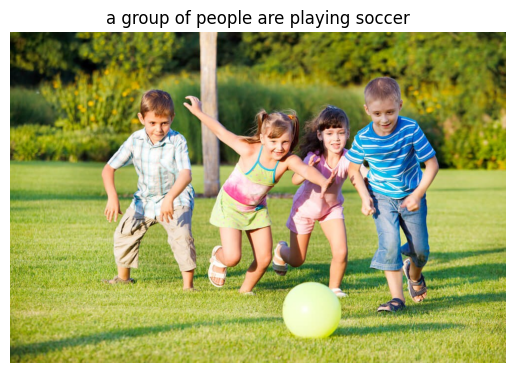

In [68]:
new_image_path = 'testImages/children_playing.jpg'
caption = caption_new_image(new_image_path, model_lstm, tokenizer, max_length)

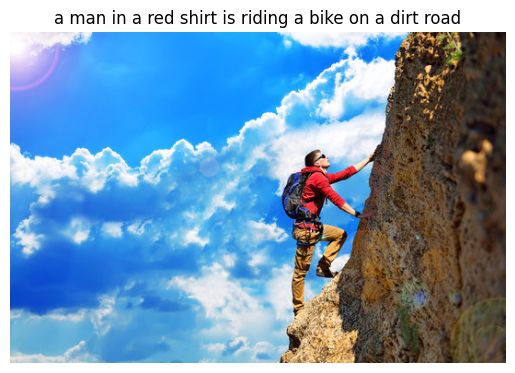

In [69]:

new_image_path = 'testImages/hill_climb.jpg'
caption = caption_new_image(new_image_path, model_lstm, tokenizer, max_length)


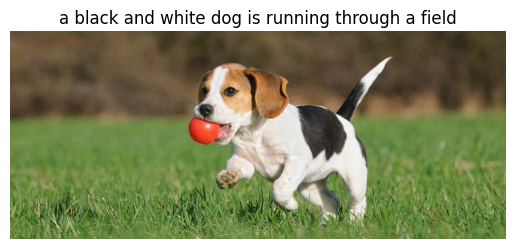

In [70]:
new_image_path = 'testImages/dog-playtime-927x388.jpg'
caption = caption_new_image(new_image_path, model_lstm, tokenizer, max_length)
